# Split Dataset Into 3 Set
Do not run this code if you have run it before

In [ ]:
#install split_folders library
!pip install split_folders

In [ ]:
#import splitfolders library
import splitfolders

In [ ]:
#split dataset into 3 folder(train, test, val)
input_folder = "Lego/Input_dataset"
output = "Lego/processed_data"
splitfolders.ratio(input_folder, output, seed = 1337, ratio=(.6, .2, .2))


# Lego Block Image Classification


In [1]:
#helper library
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop

from skimage.transform import resize

In [2]:
img = image.load_img("Lego/processed_data/train/2357 Brick corner 1x2x2/201706171206-0001.png")

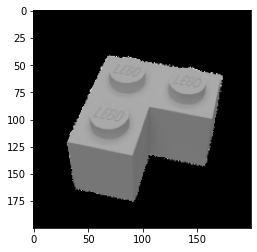

In [3]:
plt.imshow(img)

In [4]:
cv2.imread("Lego/processed_data/train/2357 Brick corner 1x2x2/201706171206-0001.png").shape

(200, 200, 3)

# Generate training and validation dataset

In [13]:
def resize_pad(img):
    old_size = img.shape[:2]
    ratio = 200. / max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    img = resize(img, output_shape=new_size, mode='edge', preserve_range=True)
    
    delta_w = 200 - new_size[1]
    delta_h = 200 - new_size[0]
    padding = ((delta_h//2, delta_h-(delta_h//2)), (delta_w//2, delta_w-(delta_w//2)), (0, 0))
    
    img = np.pad(img, padding, 'edge')
    
    return img

def preprocessing_train(x):
    x = resize_pad(x)
    return x

def preprocessing_val(x):
    x = resize_pad(x)
    return x

def preprocessing_test(x):
    x = resize_pad(x)
    return x
    
train = ImageDataGenerator(
                        preprocessing_function=preprocessing_train,
                        rescale = 1/255,
                          zoom_range=0.05,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        horizontal_flip=True,
                        vertical_flip=True,
                        rotation_range=90,
                        validation_split=0.1)
validation = ImageDataGenerator(
                        preprocessing_function=preprocessing_val,
                        rescale = 1/255,
                        validation_split=0.1)
test = ImageDataGenerator(
                        preprocessing_function=preprocessing_test,
                        rescale = 1/255)

In [6]:
train_dataset = train.flow_from_directory('Lego/processed_data/train/',
                                          color_mode='grayscale',
                                          target_size = (200,200),
                                          batch_size = 32,
                                          class_mode = 'categorical',
                                          subset='training',
                                          seed=0)

Found 3445 images belonging to 16 classes.


In [7]:
validation_dataset = validation.flow_from_directory('Lego/processed_data/val/',
                                        color_mode='grayscale',
                                        target_size = (200,200),
                                        batch_size = 32,
                                        class_mode = 'categorical',
                                        subset='validation',
                                        seed=0)

Found 127 images belonging to 16 classes.


In [51]:
test_dataset = test.flow_from_directory('Lego/processed_data/test/',
                                        color_mode='grayscale',
                                        target_size = (200,200),
                                        batch_size = 1,
                                        class_mode = 'categorical',
                                        shuffle = False,
                                        seed=0)

Found 1277 images belonging to 16 classes.


In [8]:
#classes
train_dataset.class_indices

{'11214 Bush 3M friction with Cross axle': 0,
 '18651 Cross Axle 2M with Snap friction': 1,
 '2357 Brick corner 1x2x2': 2,
 '3003 Brick 2x2': 3,
 '3004 Brick 1x2': 4,
 '3005 Brick 1x1': 5,
 '3022 Plate 2x2': 6,
 '3023 Plate 1x2': 7,
 '3024 Plate 1x1': 8,
 '3040 Roof Tile 1x2x45deg': 9,
 '3069 Flat Tile 1x2': 10,
 '32123 half Bush': 11,
 '3673 Peg 2M': 12,
 '3713 Bush for Cross Axle': 13,
 '3794 Plate 1X2 with 1 Knob': 14,
 '6632 Technic Lever 3M': 15}

In [9]:
train_dataset.classes

array([ 0,  0,  0, ..., 15, 15, 15])

# Build Model

Set up layers

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,kernel_size=3, activation = 'relu', padding = 'same', input_shape = (200,200,1)),
    tf.keras.layers.MaxPool2D(),
    #
    tf.keras.layers.Conv2D(32,kernel_size=3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(),
    #
    tf.keras.layers.Conv2D(64,kernel_size=3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(),
    #
    tf.keras.layers.Flatten(),
    ##
    tf.keras.layers.Dense(512, activation = 'relu'),
    ##
    tf.keras.layers.Dense(128, activation = 'relu'),
    ##
    tf.keras.layers.Dense(16, activation='softmax')
    ])

In [11]:
model.compile(loss= 'categorical_crossentropy',
              optimizer='adam',
             #optimizer = RMSprop(lr=0.001),
             metrics = ['accuracy'])

In [12]:
model_fit = model.fit(train_dataset, epochs = 10, validation_data = validation_dataset)

Epoch 1/10
108/108 [==============================] - 1663s 15s/step - loss: 1.5677 - accuracy: 0.4299 - val_loss: 1.2276 - val_accuracy: 0.5276
Epoch 2/10
108/108 [==============================] - 1663s 15s/step - loss: 1.1528 - accuracy: 0.5478 - val_loss: 1.0738 - val_accuracy: 0.5748
Epoch 3/10
108/108 [==============================] - 1650s 15s/step - loss: 1.0732 - accuracy: 0.5753 - val_loss: 0.9664 - val_accuracy: 0.6142
Epoch 4/10
108/108 [==============================] - 1680s 16s/step - loss: 0.9752 - accuracy: 0.6209 - val_loss: 0.8711 - val_accuracy: 0.6535
Epoch 5/10
108/108 [==============================] - 1822s 17s/step - loss: 0.8978 - accuracy: 0.6499 - val_loss: 0.7538 - val_accuracy: 0.7008
Epoch 6/10
108/108 [==============================] - 3775s 35s/step - loss: 0.8346 - accuracy: 0.6772 - val_loss: 0.7355 - val_accuracy: 0.7008
Epoch 7/10
108/108 [==============================] - 1748s 16s/step - loss: 0.7844 - accuracy: 0.6946 - val_loss: 0.6493 - val_ac

# Evaluate Accuracy

In [49]:
model.save('Lego/Saved_model/lego.h5')

In [50]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

print('\nTest accuracy:', test_acc)

40/40 - 252s - loss: 0.5043 - accuracy: 0.7964

Test accuracy: 0.7963978052139282


# Make and Verify Predictions

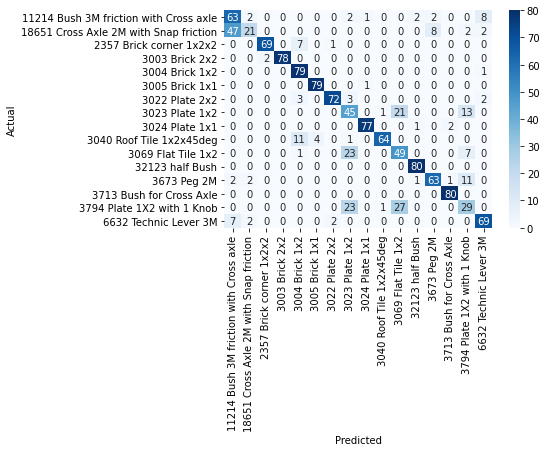

Test accuracy: Predicted
11214 Bush 3M friction with Cross axle     854.621849
18651 Cross Axle 2M with Snap friction    3766.666667
2357 Brick corner 1x2x2                   1432.394366
3003 Brick 2x2                            1303.846154
3004 Brick 1x2                            1006.930693
3005 Brick 1x1                            1225.301205
3022 Plate 2x2                            1356.000000
3023 Plate 1x2                            1048.453608
3024 Plate 1x1                            1287.341772
3040 Roof Tile 1x2x45deg                  1540.909091
3069 Flat Tile 1x2                        1048.453608
32123 half Bush                           1210.714286
3673 Peg 2M                               1393.150685
3713 Bush for Cross Axle                  1225.301205
3794 Plate 1X2 with 1 Knob                1640.322581
6632 Technic Lever 3M                     1240.243902
dtype: float64


In [55]:
import pandas as pd
import seaborn as sn

model = tf.keras.models.load_model("Lego/Saved_model/lego.h5")
filenames = test_dataset.filenames
nb_samples = len(test_dataset)
y_prob=[]
y_act=[]
test_dataset.reset()
for _ in range(nb_samples):
    X_test, Y_test = test_dataset.next()
    y_prob.append(model.predict(X_test))
    y_act.append(Y_test)
    
predicted_class = [list(train_dataset.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_dataset.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class, actual_class]).T, columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, cmap='Blues', annot=True, fmt='d')
plt.show()
print('Test accuracy: {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum()*100)))